In [1]:
name = 'rsg_g2_angle2_edge_nostuck_penupstart3_jump1x41_rarependown_raregen'
model_path = 'model/' + name + ".h5"

In [2]:
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Concatenate, Input, MaxPooling2D, Activation, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard
import matplotlib.pyplot as plt
import numpy as np

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

class DoodleSDQModel():
    def __init__(self, global_input_size, local_input_size, output_size):
        #super(DoodleSDQModel, self).__init__()
        self.global_input_size = global_input_size
        self.local_input_size = local_input_size
        self.output_size = output_size
        
        self.model = self._create_model()
        
        # class weight: down=1, up=0.5
#         self.class_weight = {i:1 if i<121 else 0.5 for i in range(output_size)}
        
        
    def _create_model(self):
        local_input = tf.keras.Input(shape=self.local_input_size)
        global_input = tf.keras.Input(shape=self.global_input_size)
        
        inputs = [global_input, local_input]
        
        x_local = self._create_local_CNN(local_input)
        x_global = self._create_global_CNN(global_input)
        
        x = Concatenate(axis=1)([x_global, x_local])
        
        x = Dense(2048, activation='relu')(x)
        x = Dropout(.5)(x)
        x = Dense(self.output_size)(x)
        outputs = Activation("softmax") (x)
        return Model(inputs, outputs, name="doodle_dqn")

    def _create_global_CNN(self, input):
        
        x = Conv2D(32, (8,8), strides=(4,4), padding='same', activation='relu')(input)
        # x = Activation("relu")(x)
        x = MaxPooling2D((2,2))(x)
        
        x = Conv2D(64, (4,4), strides=(2,2), padding='same', activation='relu')(x)
        # x = Activation("relu")(x)
        x = MaxPooling2D((2,2))(x)
        
        x = Conv2D(64, (3,3), strides=(1,1), padding='same', activation='relu')(x)
        # x = Activation("relu")(x)
        x = MaxPooling2D((2,2))(x)
        
        x = Flatten()(x)
        
        return x

    def _create_local_CNN(self, input):
        x = Conv2D(128, (11,11), padding='same', activation='relu')(input)
        # x = Activation("relu")(x)
        x = MaxPooling2D((2,2))(x)
        
        x = Flatten()(x)
        return x
    
    def train(self,training_gen, validation_data, epochs, init_epoch=0):
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)
        early_stopping = EarlyStopping(monitor='val_loss',min_delta=0, patience=8, verbose=1,)
        tensorboard = TensorBoard(
                              log_dir='logs/'+name,
                              histogram_freq=0,
                              write_images=True
                            )
        
        self.epochs = epochs
        self.model.compile(optimizer=Adam(lr=.003), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        self.history = self.model.fit(training_gen,\
                                      validation_data=validation_data, \
                                      validation_steps= len(validation_data),\
                                      epochs=epochs, \
                                      initial_epoch=init_epoch,\
                                      callbacks=[reduce_lr, tensorboard, early_stopping], \
#                                       class_weight=self.class_weight, \
                                      verbose=1)
    
    def plot(self):
        acc = self.history.history['accuracy']
        val_acc = self.history.history['val_accuracy']

        loss = self.history.history['loss']
        val_loss = self.history.history['val_loss']

        epochs_range = range(self.epochs)

        plt.figure(figsize=(8, 8))
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label='Training Accuracy')
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label='Training Loss')
        plt.plot(epochs_range, val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.show()
#     def _create_dense(self):
#         input_shape = (None, self.model_global.output_shape[1] + self.model_local.output_shape[1])
#         model = Sequential()
#         model.add(Input(shape=input_shape))
#         model.add(Dense(256, activation="relu"))
#         model.add(Dense(self.output_size, activation="softmax"))
#         return model

#     def call(self, inputs, patches):
#         print("call")
#         global_input = inputs
#         local_input = patches
#         global_features = self.model_global(global_input)
#         local_features = self.model_local(local_input)
        
#         x = Concatenate(axis=1)([global_features, local_features])
#         y_pred = self.dense(x)
        
#         return y_pred


In [3]:
from random_stroke_generator import RandomStrokeGenerator

In [4]:
training_gen = RandomStrokeGenerator(batch_size=968,
                                     num_data=12100, 
                                     min_strokes=32, 
                                     max_strokes=64, 
                                     jumping_rate=0.1,
                                     max_jumping_step=41
                                    )
valid_gen = RandomStrokeGenerator(batch_size=484,
                                  num_data=4840, 
                                  min_strokes=32, 
                                  max_strokes=64,
                                  jumping_rate=0.1,
                                  max_jumping_step=41
                                 )

In [5]:
global_size = (84,84,4)
local_size = (11,11,2)
model1 = DoodleSDQModel(global_input_size=global_size, local_input_size=local_size, output_size=242)
model_base = DoodleSDQModel(global_input_size=global_size, local_input_size=local_size, output_size=242)


In [6]:
model1.model.summary()

Model: "doodle_dqn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 84, 84, 4)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 21, 21, 32)   8224        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 10, 10, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 5, 5, 64)     32832       max_pooling2d_1[0][0]            
_________________________________________________________________________________________

In [7]:
# from tensorflow import keras

# keras.utils.plot_model(model1.model, "doodle_sdq_maxpool.png", show_shapes=True)

In [8]:
model1.train(training_gen, valid_gen, 200, init_epoch=-1)

Epoch 0/200
13/13 [==============================] - 2s 186ms/step - loss: 5.1038 - accuracy: 0.0493 - val_loss: 4.4390 - val_accuracy: 0.0870 - lr: 0.0030
Epoch 1/200
13/13 [==============================] - 2s 161ms/step - loss: 4.1430 - accuracy: 0.1113 - val_loss: 3.7004 - val_accuracy: 0.1584 - lr: 0.0030
Epoch 2/200
13/13 [==============================] - 2s 164ms/step - loss: 3.4989 - accuracy: 0.1908 - val_loss: 3.2300 - val_accuracy: 0.2391 - lr: 0.0030
Epoch 3/200
13/13 [==============================] - 2s 170ms/step - loss: 3.1439 - accuracy: 0.2420 - val_loss: 2.9151 - val_accuracy: 0.3091 - lr: 0.0030
Epoch 4/200
13/13 [==============================] - 2s 173ms/step - loss: 2.9060 - accuracy: 0.2819 - val_loss: 2.7677 - val_accuracy: 0.2910 - lr: 0.0030
Epoch 5/200
13/13 [==============================] - 2s 155ms/step - loss: 2.7194 - accuracy: 0.2989 - val_loss: 2.4717 - val_accuracy: 0.3379 - lr: 0.0030
Epoch 6/200
13/13 [==============================] - 2s 158ms/st

In [9]:
! tensorboard --logdir "logs/0405_n"

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.3.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [9]:
X, y = training_gen.__getitem__(1)

In [10]:
model1.model.evaluate(training_gen)

13/13 [==============================] - 1s 61ms/step - loss: 1.7945 - accuracy: 0.5243


[1.7945075035095215, 0.5242975354194641]

In [11]:
model1.model.evaluate(valid_gen)

10/10 [==============================] - 2s 177ms/step - loss: 1.8200 - accuracy: 0.5320


[1.819952130317688, 0.5320248007774353]

In [16]:
pred = model1.model.predict(X)
print(np.argmax(pred, axis=1))

[145 201 171 230 231 136 212 186 222 198 216 135 144 147 171 140 183 175
 174 178 174 147 227 156 208 158 171 134 128 217 222 126 122 147 200 189
 223 190 175 216 168 227 141 128 177 132 241 127 209 136 187 158 128 190
 185 237 176 236 229 150 183 185 210 161 122 199 215 213 214 223 225 237
 234 181 122 234 238 135 163 221 124 235 238 239 208 186 177 221 196 147
 194 241 126 161 223 163 209 141 211 129 142 198 227 233 173 177 162 225
 148 190 202 229 122 166 146 135 219 198 212 176 192 229 172 185 155 124
 198 143 210 155 210 163 139 187 145 130 137 208 192 165 123 127 175 155
 163 198 238 125 215 240 127 142 204 200 157 235 210 198 209 232 241 229
 131 201 121 236 189 148 182 204 240 215 140 211 165 220 144 128 152 147
 177 147 125 157 127 211 140 210 125 173 214 201 126 227 152 143 186 200
 164 173 142 142 176 174 222 179 145 182 201 235 177 235 214 221 238 166
 165 154 141 204 214 211 143 199 128 199 166 127 174 167 208 159 241 139
 225 231 162 156 172 199 171 207 233 214 153 223 17

In [24]:
print(y)

[17 90 36 22 37 19 47 27 76 22 57 42 36 16  8 38 45 19 18 41  9 80 10 34
 28 65  4 32 77 38 42 78 79 46 23 10 54 10 95 71  5 86 18 94 62 79 10 44
 36  9  0 91 26 85 76 23 78  5 92 83 32 83 15 57 70 81 78 29 60 68 25  8
 40 26 33  8 39 77 80  6 65 32 59  7 55 74  7  8 84 48 79 56 39 71 76 12
 23 16 78 48 10 68 14 49 54 88 22 77 59  6 70 62  1 90 70 44  6 48 36 68
 70 62 88 63 70 20 26 92 48  8 92  8 13 19 50 56 61 83 46 36 55  6 70 15
 70  8 25 86 39 34 18 89 33 82 72 72 71 20 67 25 58 55 54 50 45 81 63 90
 46 96 60 75 70 33 52 70 49 15 49 31 95 49 36 51 97 93  8 17  9  2 52 26
 30  6 38 43  0 47 63 14 56 61 80 39 96 19 74 16 34 83 39 21 62 52 58 65
 34 32 82 72 47 62 54 40 19 40 84 63 31 61 86 23 57 75 96 28 49 60 78 23
 78 45 76 60 59 45 90 94 31 20 42 84 67 25 63 12  4 61 28 50 69 67 86 54
 41 54 15 50 84 71 65 96 90 49 97 11 12 69 14 85 19 84 80 12 59 90  1 70
 38 14 83 94 23 75 66 11 91 17 62 15 35 38 13 93 46 50 56 49 45 74 59 57
 33 50 64 83 90 10 51 80 44 90 40 60 80 38 94 85 97

In [ ]:
import numpy as np
y_pred = np.argmax(pred, axis=1)
print(y_pred[y_pred!=y])

In [ ]:
X2, y2 = valid_gen.__getitem__(1)

pred2 = model1.model(X2)

print(np.argmax(pred2, axis=1)==y2)

In [ ]:
import numpy as np
a = X[0][0,:,:,2]
ind = np.unravel_index(np.argmin(a), a.shape)
print(ind)


In [ ]:
print(84*84)

In [9]:
from environment.drawer import Drawer
import numpy as np

drawer = Drawer()
def draw_action(canvas, distance_map, action):
    drawer.set_canvas(canvas)
    pen_pos = np.unravel_index(np.argmin(distance_map), distance_map.shape)
    drawer.set_pen_position((pen_pos[1], pen_pos[0]))
    drawer.do_action(action)
    return np.copy(drawer.get_canvas())



In [ ]:
import matplotlib.pyplot as plt

X,y = training_gen.__getitem__(1)
pred = model_base.model.predict(X)
y_pred = np.argmax(pred, axis=1)

# Plot
fig=plt.figure(figsize=(12, 64))
cols = 6
rows = 24

for i in range(12):
    canvas = X[0][i,:,:,1]
    distance_map = X[0][i,:,:,2]
    action = y[i]
    action_pred = y_pred[i]
    canv_truth = draw_action(canvas, distance_map, action)
    canv_pred = draw_action(canvas, distance_map, action_pred)
    fig.add_subplot(rows, cols, 3*i+1)
    plt.imshow(canv_truth)
    fig.add_subplot(rows, cols, 3*i+2)
    plt.imshow(canv_pred)
    
    fig.add_subplot(rows, cols, 3*i+3)
    plt.imshow(distance_map)
    
plt.show()
    

--- After training


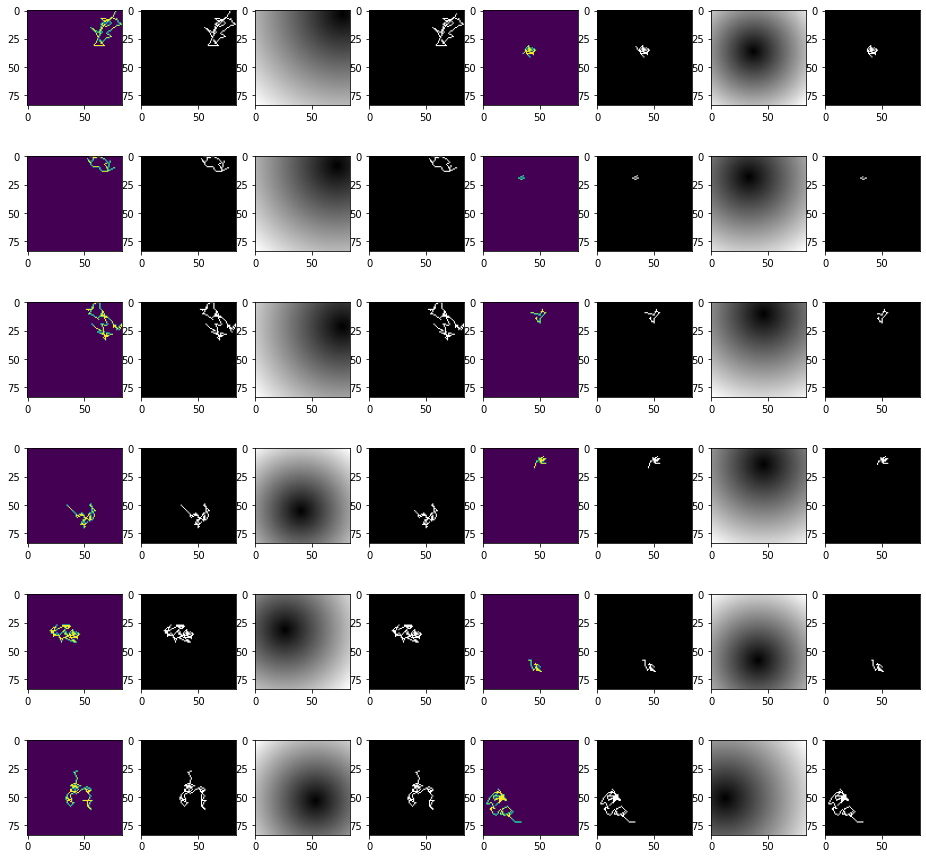

In [10]:
import matplotlib.pyplot as plt
print("--- After training")
X,y = training_gen.__getitem__(0)
pred = model1.model.predict(X)
y_pred = np.argmax(pred, axis=1)

# Plot
fig=plt.figure(figsize=(16, 64))
cols = 8
rows = 24

for i in range(12):
    ref = X[0][i,:,:,0]
    canvas = X[0][i,:,:,0]
    distance_map = X[0][i,:,:,2]
    action = y[i]
    action_pred = y_pred[i]
    canv_truth = draw_action(canvas, distance_map, action)
    canv_pred = draw_action(canvas, distance_map, action_pred)
    fig.add_subplot(rows, cols, 4*i+1)
    plt.imshow(canv_truth)
    fig.add_subplot(rows, cols, 4*i+2)
    plt.imshow(canv_pred, cmap='gray')
    
    fig.add_subplot(rows, cols, 4*i+3)
    plt.imshow(distance_map, cmap='gray')
    
    fig.add_subplot(rows, cols, 4*i+4)
    plt.imshow(ref, cmap='gray')
    
plt.show()

In [13]:
# valid_gen.on_epoch_end()
X,y = valid_gen.__getitem__(0)
Ys = y
pred = model1.model.predict(X)
y_pred = np.argmax(pred, axis=1)
y_preds = y_pred
for i in range(1, len(valid_gen)-1):
    X,y = valid_gen.__getitem__(i)
    pred = model1.model.predict(X)
    y_pred = np.argmax(pred, axis=1)
    Ys = np.concatenate((Ys,y))
    y_preds = np.concatenate((y_preds,y_pred))


UnboundLocalError: local variable 'batch_outputs' referenced before assignment

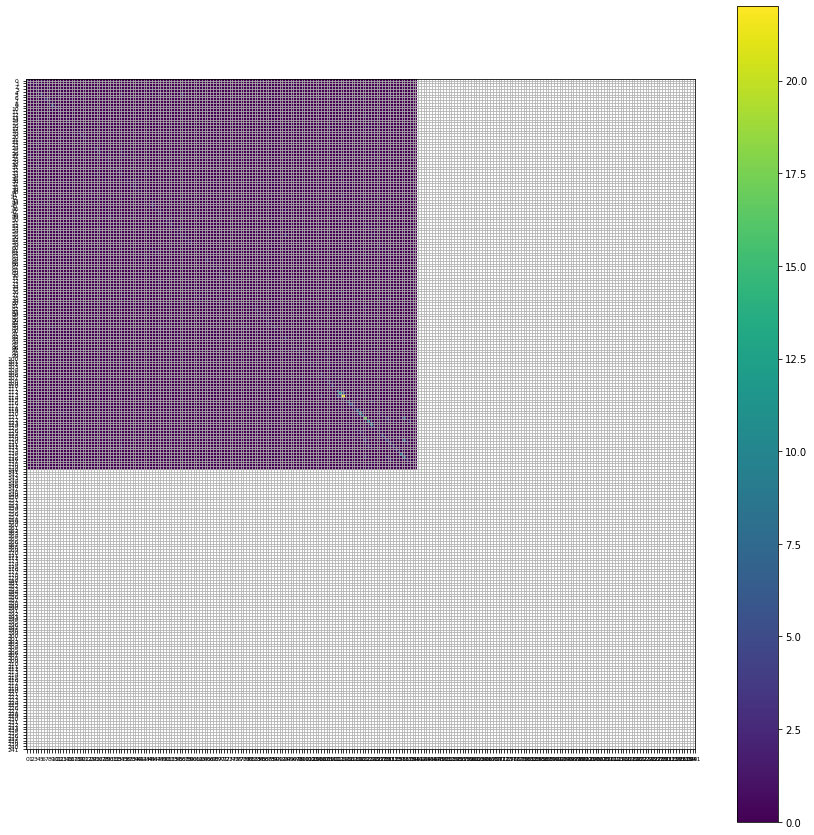

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_cf(confmat):
    import numpy as np
    import matplotlib.pyplot as plt

#     confmat=np.random.rand(90,90)
    ticks=np.linspace(0, 241,num=242)
    plt.figure(figsize=(15, 15))
    plt.imshow(confmat, interpolation='none')
    plt.colorbar()
    plt.xticks(ticks,fontsize=6)
    plt.yticks(ticks,fontsize=6)
    plt.grid(True)
    plt.show()

cf_matrix = confusion_matrix(Ys, y_preds)
plot_cf(cf_matrix)


In [ ]:
from environment.drawer import Drawer
import numpy as np
import matplotlib.pyplot as plt
import cv2

def generate_test(drawer, strokes=32):
    actions = np.random.randint(0, 242, strokes)
    for action in actions:
        drawer.do_action(action)
        
    return drawer.get_canvas()

def get_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (84,84))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = 1-(img / 255.0)
    print(img)
    img = np.array(img, dtype=np.float)
    print(img.shape, type(img), img.dtype)
    return img

In [ ]:
from copy import deepcopy

drawer_test = Drawer()
drawer_test.reset()
drawer_test.set_pen_position((40,40))
strokes = 200

drawer_ref = deepcopy(drawer_test)
# Test using random stroke
# ref = generate_test(drawer_ref, strokes)

# Test using image
ref = get_image('../Sketch/PhotoSketch/Exp/PhotoSketch/Results/bedroom.png')
drawer_ref.set_canvas(ref)


fig=plt.figure(figsize=(16, 8))
cols = 8
rows = 1
fig.add_subplot(rows, cols, 1)
plt.imshow(ref, cmap='gray')
fig.add_subplot(rows, cols, 2)
print(drawer_test.get_canvas())
plt.imshow(drawer_test.get_canvas(), cmap='gray')

plt.show()
canvas = []

for i in range(strokes):
    # Prepare X
    dis = drawer_test.get_distance_map()
    col = drawer_test.get_color_map()
    cp = drawer_test.get_patch()
    rp = drawer_ref.get_patch(drawer_test.get_pen_position())
    x = np.stack( (ref, drawer_test.get_canvas(), dis, col), axis=2)
    p = np.stack( (cp, rp), axis=2)
    
    x = np.expand_dims(x, axis=0)
    p = np.expand_dims(p, axis=0)
    
    pred = model_base.model.predict([x,p])
    action = np.argmax(pred)
    print(action)
    drawer_test.do_action(action)
    canvas.append(drawer_test.get_canvas())


In [ ]:
cols = 4
rows = strokes//cols + 1
fig=plt.figure(figsize=(4*cols, 4*rows))

for i in range(strokes):
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(canvas[i], cmap='gray')
fig.add_subplot(rows, cols, strokes+1)
plt.imshow(ref, cmap='gray')
plt.show()

In [ ]:
import cv2
import numpy as np
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('test_out/bedroom-' + name + '.avi',fourcc, 20.0, (84*2,84*1))
for i in range(strokes):
    images = (np.hstack((ref, canvas[i]))*255).astype("uint8")
    images = cv2.cvtColor(images, cv2.COLOR_GRAY2BGR)

#     cv2.imshow("Video", images)
#     cv2.imshow("patch", new_observation[4])
    out.write(images)

out.release()

In [12]:
model1.model.save(model_path)

In [13]:
model_path

'model/rsg_g2_angle_edge_nostuck_penupstart3_jump1x41_rarependown_raregen.h5'

In [ ]:
model1.model = tf.keras.models.load_model(model_path)

In [ ]:
model.summary()